# 按是否是紅眼分類

**紅眼航班資料處理**

In [20]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料並刪除價格歷史為空的列
data = pd.read_csv('/Users/yuchingchen/Documents/專題/data/history/tokyo_history_1020.csv')
data = data[['航班代碼', '出發時間', '價格歷史']].dropna(subset=['價格歷史'])

# 設定參考日期
reference_date = datetime.strptime("10/20", "%m/%d")

# 判斷是否為紅眼航班的函數
def is_red_eye_flight(departure_time):
    if "凌晨" in departure_time:
        try:
            time_obj = datetime.strptime(departure_time.replace("凌晨", "").replace("。", ""), "%I:%M")
            return 1 if 0 <= time_obj.hour < 6 else 0
        except ValueError:
            return 0
    return 0

data['紅眼航班'] = data['出發時間'].apply(is_red_eye_flight)

# 處理價格歷史，將日期轉換為剩餘天數，並計算歷史價格平均、最低價格、變異和中位數
def process_price_history(history):
    entries = history.split(", ")
    remaining_days_with_prices = []
    prices = []
    
    for entry in entries:
        if "天前" in entry:
            days_ago = int(entry.split("天前")[0].strip())
            remaining_days = days_ago
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif "今天" in entry:
            remaining_days = 0
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif " - " in entry:
            date_str, price_str = entry.split(" - ")
            date_obj = datetime.strptime(date_str, "%m/%d")
            remaining_days = (reference_date - date_obj).days
            price = int(price_str.replace("$", "").replace(",", ""))
        else:
            continue

        remaining_days_with_prices.append((remaining_days, price))
        prices.append((price, remaining_days))
    
    # 計算平均價格
    avg_price = round(sum([p[0] for p in prices]) / len(prices)) if prices else None
    
    # 計算最低價格及其對應的剩餘天數
    if prices:
        min_price = min([p[0] for p in prices])
        min_days_left = [days for price, days in prices if price == min_price][-1]
    else:
        min_price, min_days_left = None, None
    
    # 計算價格的變異（標準差）
    price_variance = pd.Series([p[0] for p in prices]).std() if prices else None

    # 計算價格的中位數
    price_median = pd.Series([p[0] for p in prices]).median() if prices else None
    
    return remaining_days_with_prices, avg_price, min_price, min_days_left, price_variance, price_median

# 對每一行的價格歷史應用處理函數並新增歷史價格平均、最低價格、最低價格剩餘天數、變異及中位數欄位
data[['剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數', '變異', '中位數']] = data['價格歷史'].apply(lambda x: pd.Series(process_price_history(x)))

# 刪除不需要的原始價格歷史欄位
data = data[['航班代碼', '出發時間', '剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數', '紅眼航班', '變異', '中位數']]

# 顯示結果
print(data.head())

     航班代碼      出發時間                                            剩餘天數及價格  \
0  IT 202   下午1:30。  [(62, 5099), (61, 5099), (60, 5099), (59, 5099...   
1  SL 394  中午12:10。  [(59, 6159), (58, 6159), (57, 6159), (56, 6159...   
2  TR 874   下午2:50。  [(44, 4188), (43, 4188), (42, 4188), (41, 4188...   
3   GK 14  中午12:50。  [(50, 5889), (49, 5889), (48, 5889), (47, 5889...   
4  IT 700   下午2:45。  [(58, 3299), (57, 3299), (56, 3699), (55, 3699...   

   歷史價格平均    最低價格  最低價格剩餘天數  紅眼航班          變異     中位數  
0  4842.0  3699.0       4.0     0  305.523539  5099.0  
1  5688.0  4495.0       6.0     0  935.627327  6159.0  
2  4202.0  3588.0      18.0     0  337.545971  4188.0  
3  4276.0  3589.0      17.0     0  894.640828  3716.0  
4  4079.0  3299.0      57.0     0  397.912573  4099.0  


**Boxplot 平均價格跟最低價格跟最低價格剩餘天數變異跟中位數（按是否紅眼航班分類）**

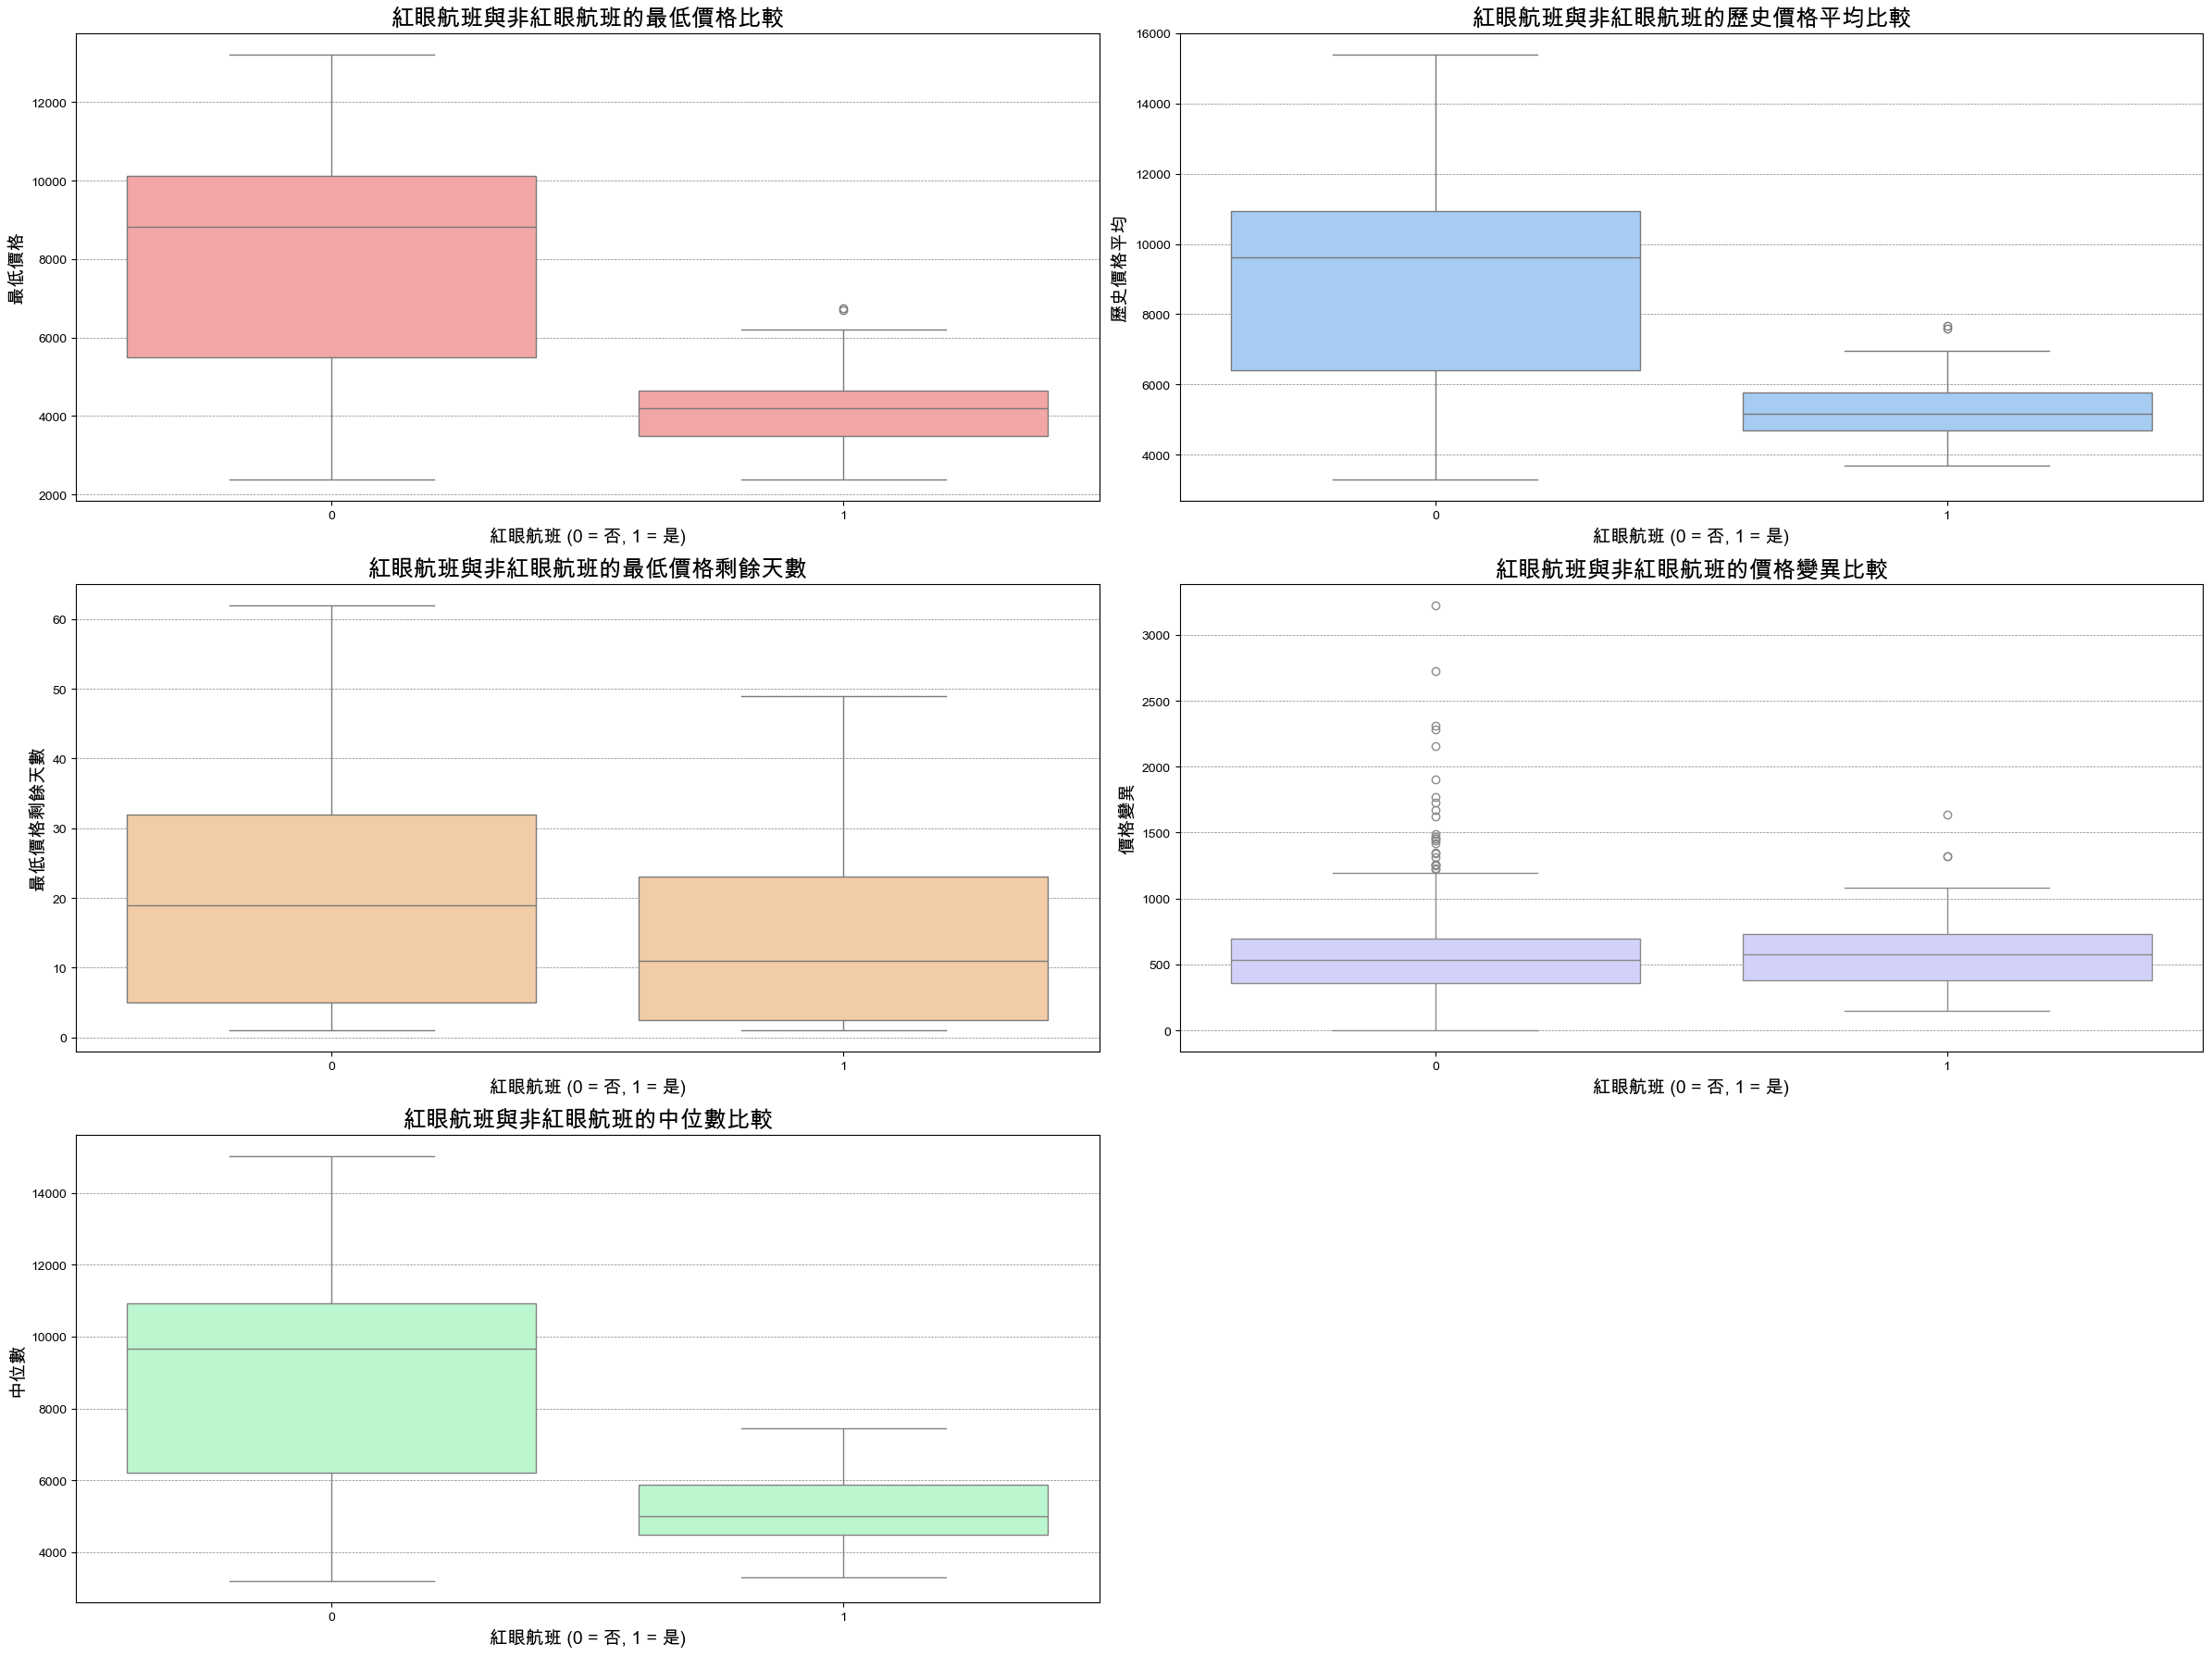

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 去除缺失值的資料
plot_data = data.dropna(subset=['航班代碼', '最低價格', '最低價格剩餘天數', '歷史價格平均', '變異', '中位數'])

# 創建子圖，分別繪製最低價格、歷史價格平均、最低價格剩餘天數、價格變異和中位數的盒狀圖
fig, axes = plt.subplots(3, 2, figsize=(24, 18))  # 調整為 3x2 網格以容納第五個圖

# 調整圖表標題字體大小
title_fontsize = 18
label_fontsize = 14

# 第一個子圖：紅眼航班與非紅眼航班的最低價格的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格', ax=axes[0, 0], color='#FF9999')
axes[0, 0].set_title('紅眼航班與非紅眼航班的最低價格比較', fontsize=title_fontsize)
axes[0, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 0].set_ylabel('最低價格', fontsize=label_fontsize)
axes[0, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第二個子圖：紅眼航班與非紅眼航班的歷史價格平均的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均', ax=axes[0, 1], color='#99CCFF')
axes[0, 1].set_title('紅眼航班與非紅眼航班的歷史價格平均比較', fontsize=title_fontsize)
axes[0, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('歷史價格平均', fontsize=label_fontsize)
axes[0, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第三個子圖：紅眼航班與非紅眼航班的最低價格剩餘天數的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格剩餘天數', ax=axes[1, 0], color='#FFCC99')
axes[1, 0].set_title('紅眼航班與非紅眼航班的最低價格剩餘天數', fontsize=title_fontsize)
axes[1, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[1, 0].set_ylabel('最低價格剩餘天數', fontsize=label_fontsize)
axes[1, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第四個子圖：紅眼航班與非紅眼航班的價格變異的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='變異', ax=axes[1, 1], color='#CCCCFF')
axes[1, 1].set_title('紅眼航班與非紅眼航班的價格變異比較', fontsize=title_fontsize)
axes[1, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[1, 1].set_ylabel('價格變異', fontsize=label_fontsize)
axes[1, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第五個子圖：紅眼航班與非紅眼航班的中位數的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='中位數', ax=axes[2, 0], color='#B3FFCC')
axes[2, 0].set_title('紅眼航班與非紅眼航班的中位數比較', fontsize=title_fontsize)
axes[2, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[2, 0].set_ylabel('中位數', fontsize=label_fontsize)
axes[2, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 移除未使用的子圖
axes[2, 1].axis('off')

# 調整佈局
plt.tight_layout()
plt.show()

**取對數：Boxplot 平均價格跟最低價格跟最低價格剩餘天數變異跟中位數（按是否紅眼航班分類）**

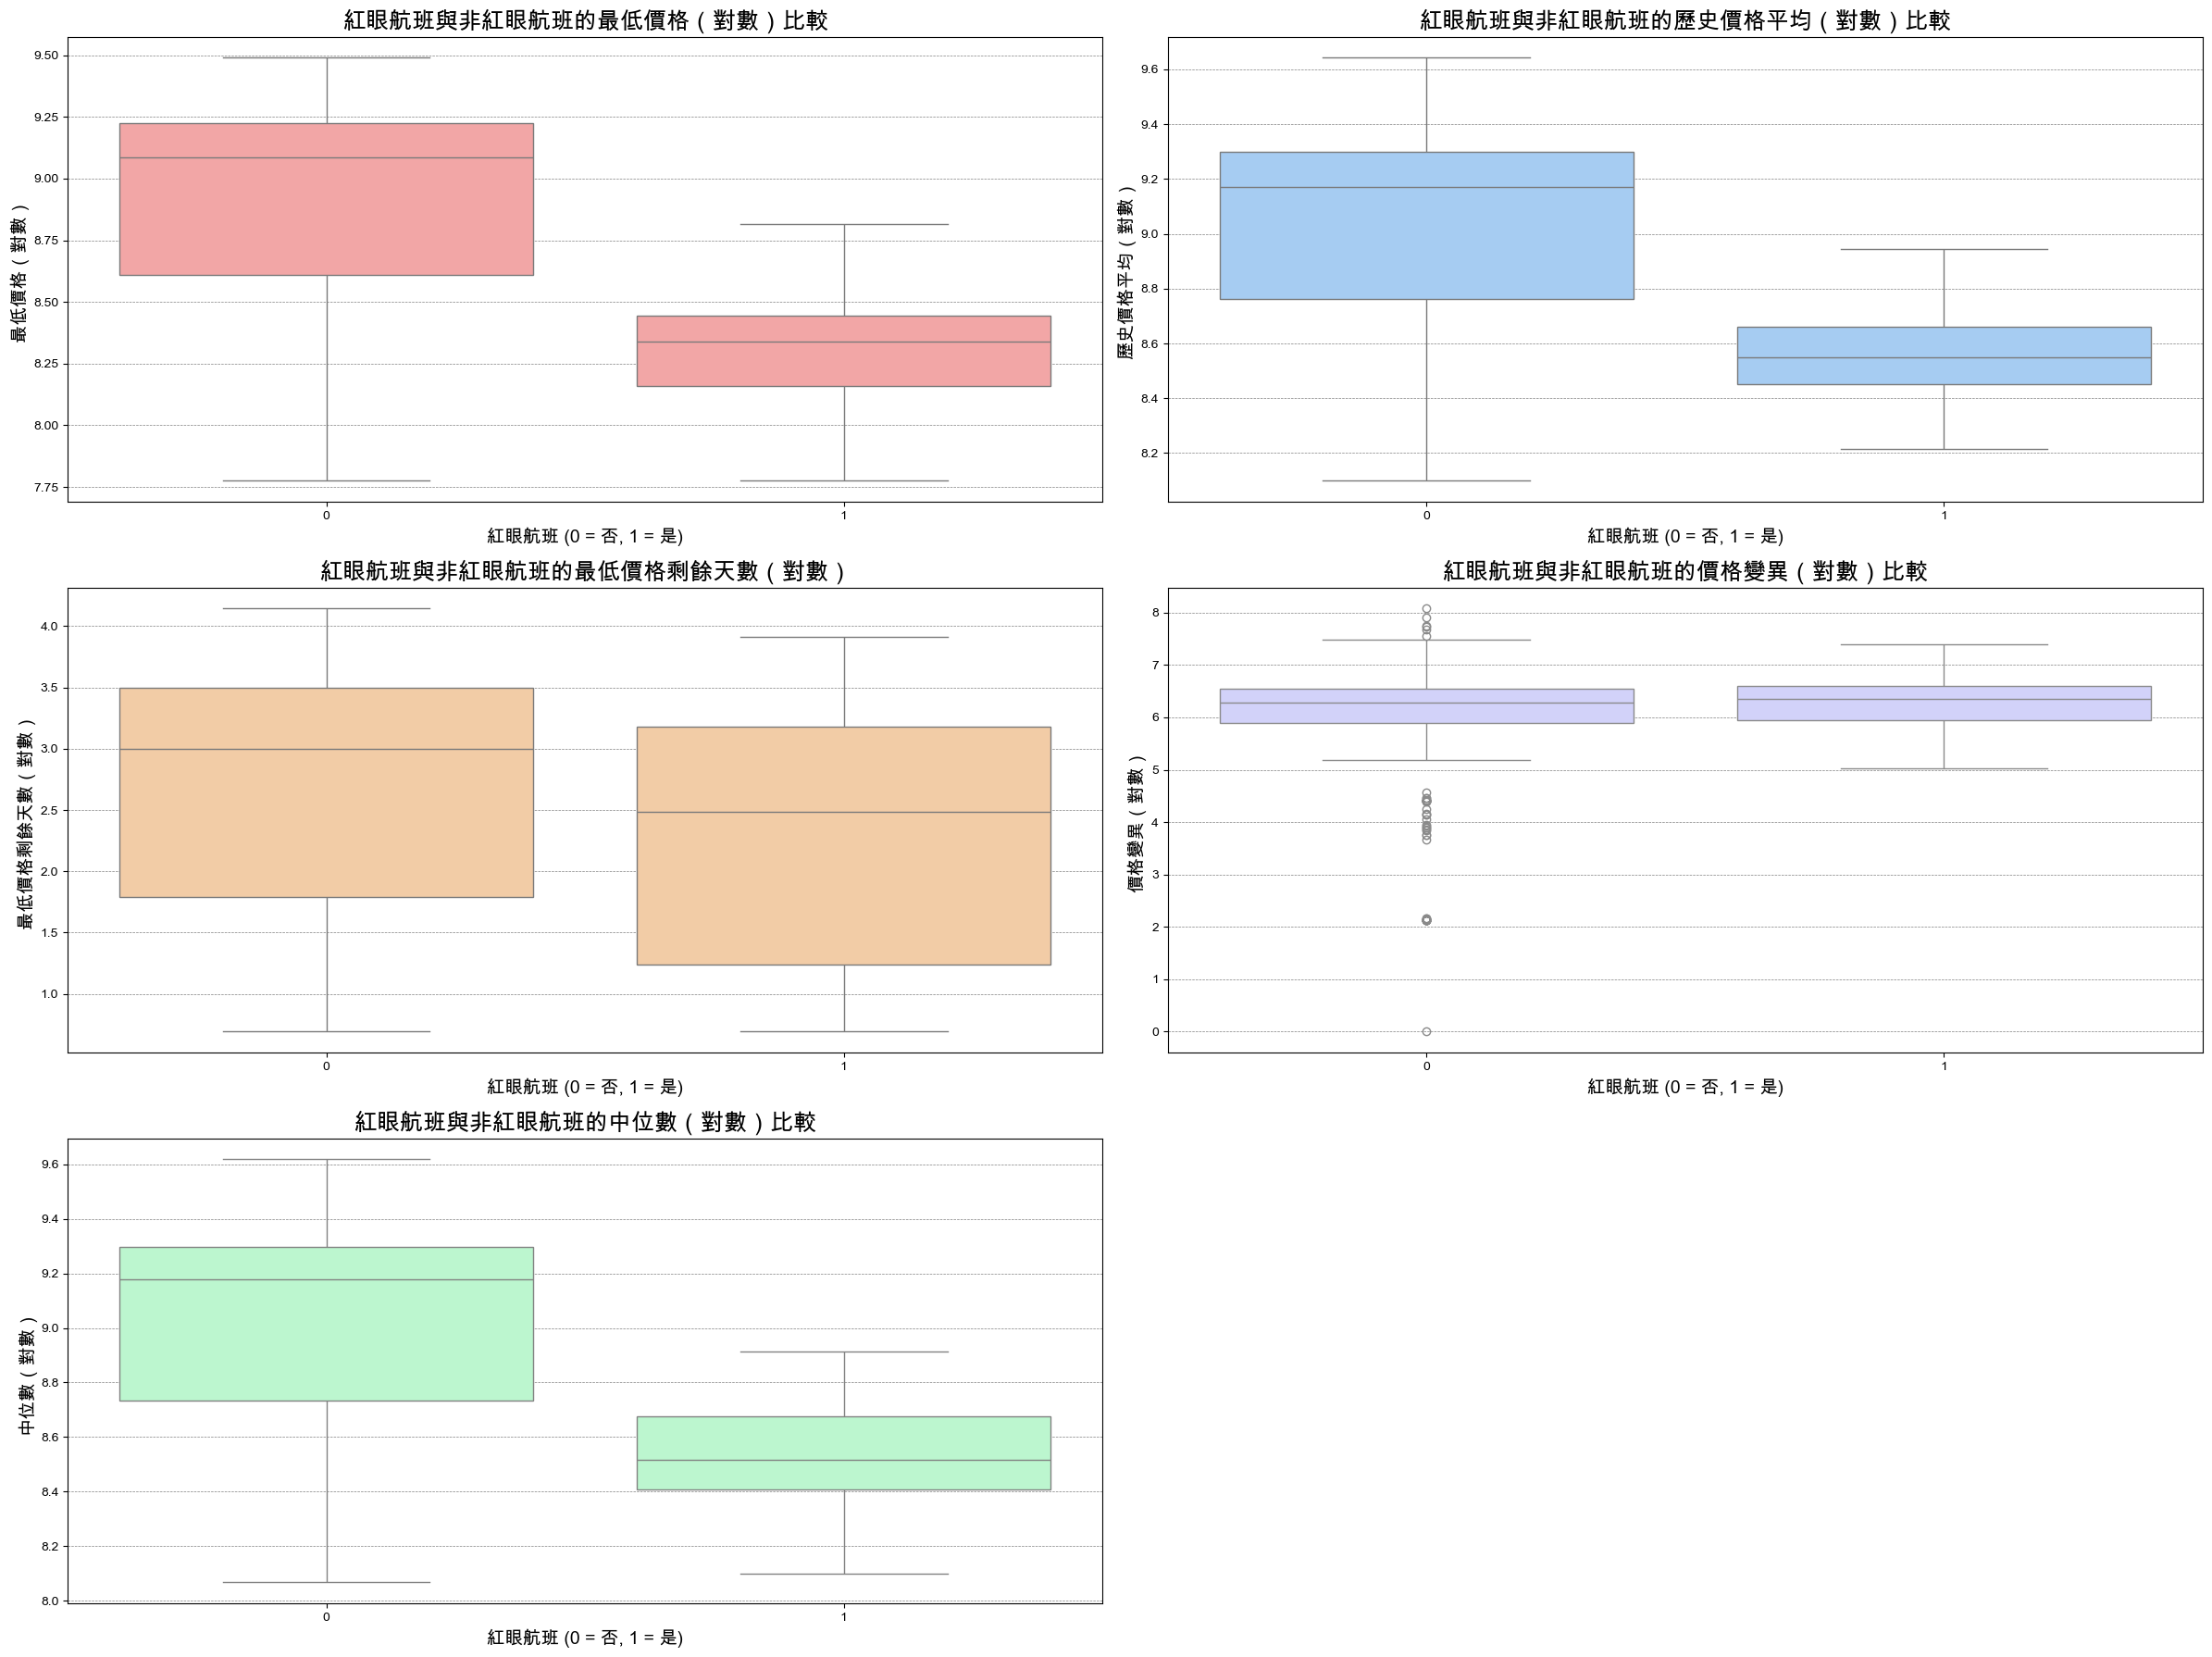

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 確保對數轉換時不會影響原始 DataFrame
plot_data = plot_data.copy()

# 將數據取對數，避免 log(0) 的錯誤，將數據加一後取對數
plot_data.loc[:, '最低價格_log'] = np.log(plot_data['最低價格'] + 1)
plot_data.loc[:, '歷史價格平均_log'] = np.log(plot_data['歷史價格平均'] + 1)
plot_data.loc[:, '最低價格剩餘天數_log'] = np.log(plot_data['最低價格剩餘天數'] + 1)
plot_data.loc[:, '變異_log'] = np.log(plot_data['變異'] + 1)
plot_data.loc[:, '中位數_log'] = np.log(plot_data['中位數'] + 1)

# 創建子圖，分別繪製對數轉換後的盒狀圖
fig, axes = plt.subplots(3, 2, figsize=(24, 18))  # 更新為 3x2 網格

# 調整圖表標題字體大小
title_fontsize = 18
label_fontsize = 14

# 第一個子圖：紅眼航班與非紅眼航班的最低價格的盒狀圖（對數）
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格_log', ax=axes[0, 0], color='#FF9999')
axes[0, 0].set_title('紅眼航班與非紅眼航班的最低價格（對數）比較', fontsize=title_fontsize)
axes[0, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 0].set_ylabel('最低價格（對數）', fontsize=label_fontsize)
axes[0, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第二個子圖：紅眼航班與非紅眼航班的歷史價格平均的盒狀圖（對數）
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均_log', ax=axes[0, 1], color='#99CCFF')
axes[0, 1].set_title('紅眼航班與非紅眼航班的歷史價格平均（對數）比較', fontsize=title_fontsize)
axes[0, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('歷史價格平均（對數）', fontsize=label_fontsize)
axes[0, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第三個子圖：紅眼航班與非紅眼航班的最低價格剩餘天數的盒狀圖（對數）
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格剩餘天數_log', ax=axes[1, 0], color='#FFCC99')
axes[1, 0].set_title('紅眼航班與非紅眼航班的最低價格剩餘天數（對數）', fontsize=title_fontsize)
axes[1, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[1, 0].set_ylabel('最低價格剩餘天數（對數）', fontsize=label_fontsize)
axes[1, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第四個子圖：紅眼航班與非紅眼航班的價格變異的盒狀圖（對數）
sns.boxplot(data=plot_data, x='紅眼航班', y='變異_log', ax=axes[1, 1], color='#CCCCFF')
axes[1, 1].set_title('紅眼航班與非紅眼航班的價格變異（對數）比較', fontsize=title_fontsize)
axes[1, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[1, 1].set_ylabel('價格變異（對數）', fontsize=label_fontsize)
axes[1, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第五個子圖：紅眼航班與非紅眼航班的中位數的盒狀圖（對數）
sns.boxplot(data=plot_data, x='紅眼航班', y='中位數_log', ax=axes[2, 0], color='#B3FFCC')
axes[2, 0].set_title('紅眼航班與非紅眼航班的中位數（對數）比較', fontsize=title_fontsize)
axes[2, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[2, 0].set_ylabel('中位數（對數）', fontsize=label_fontsize)
axes[2, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 移除未使用的子圖
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

**Histogram 平均價格跟最低價格跟最低價格剩餘天數變異跟中位數（按是否紅眼航班分類）**

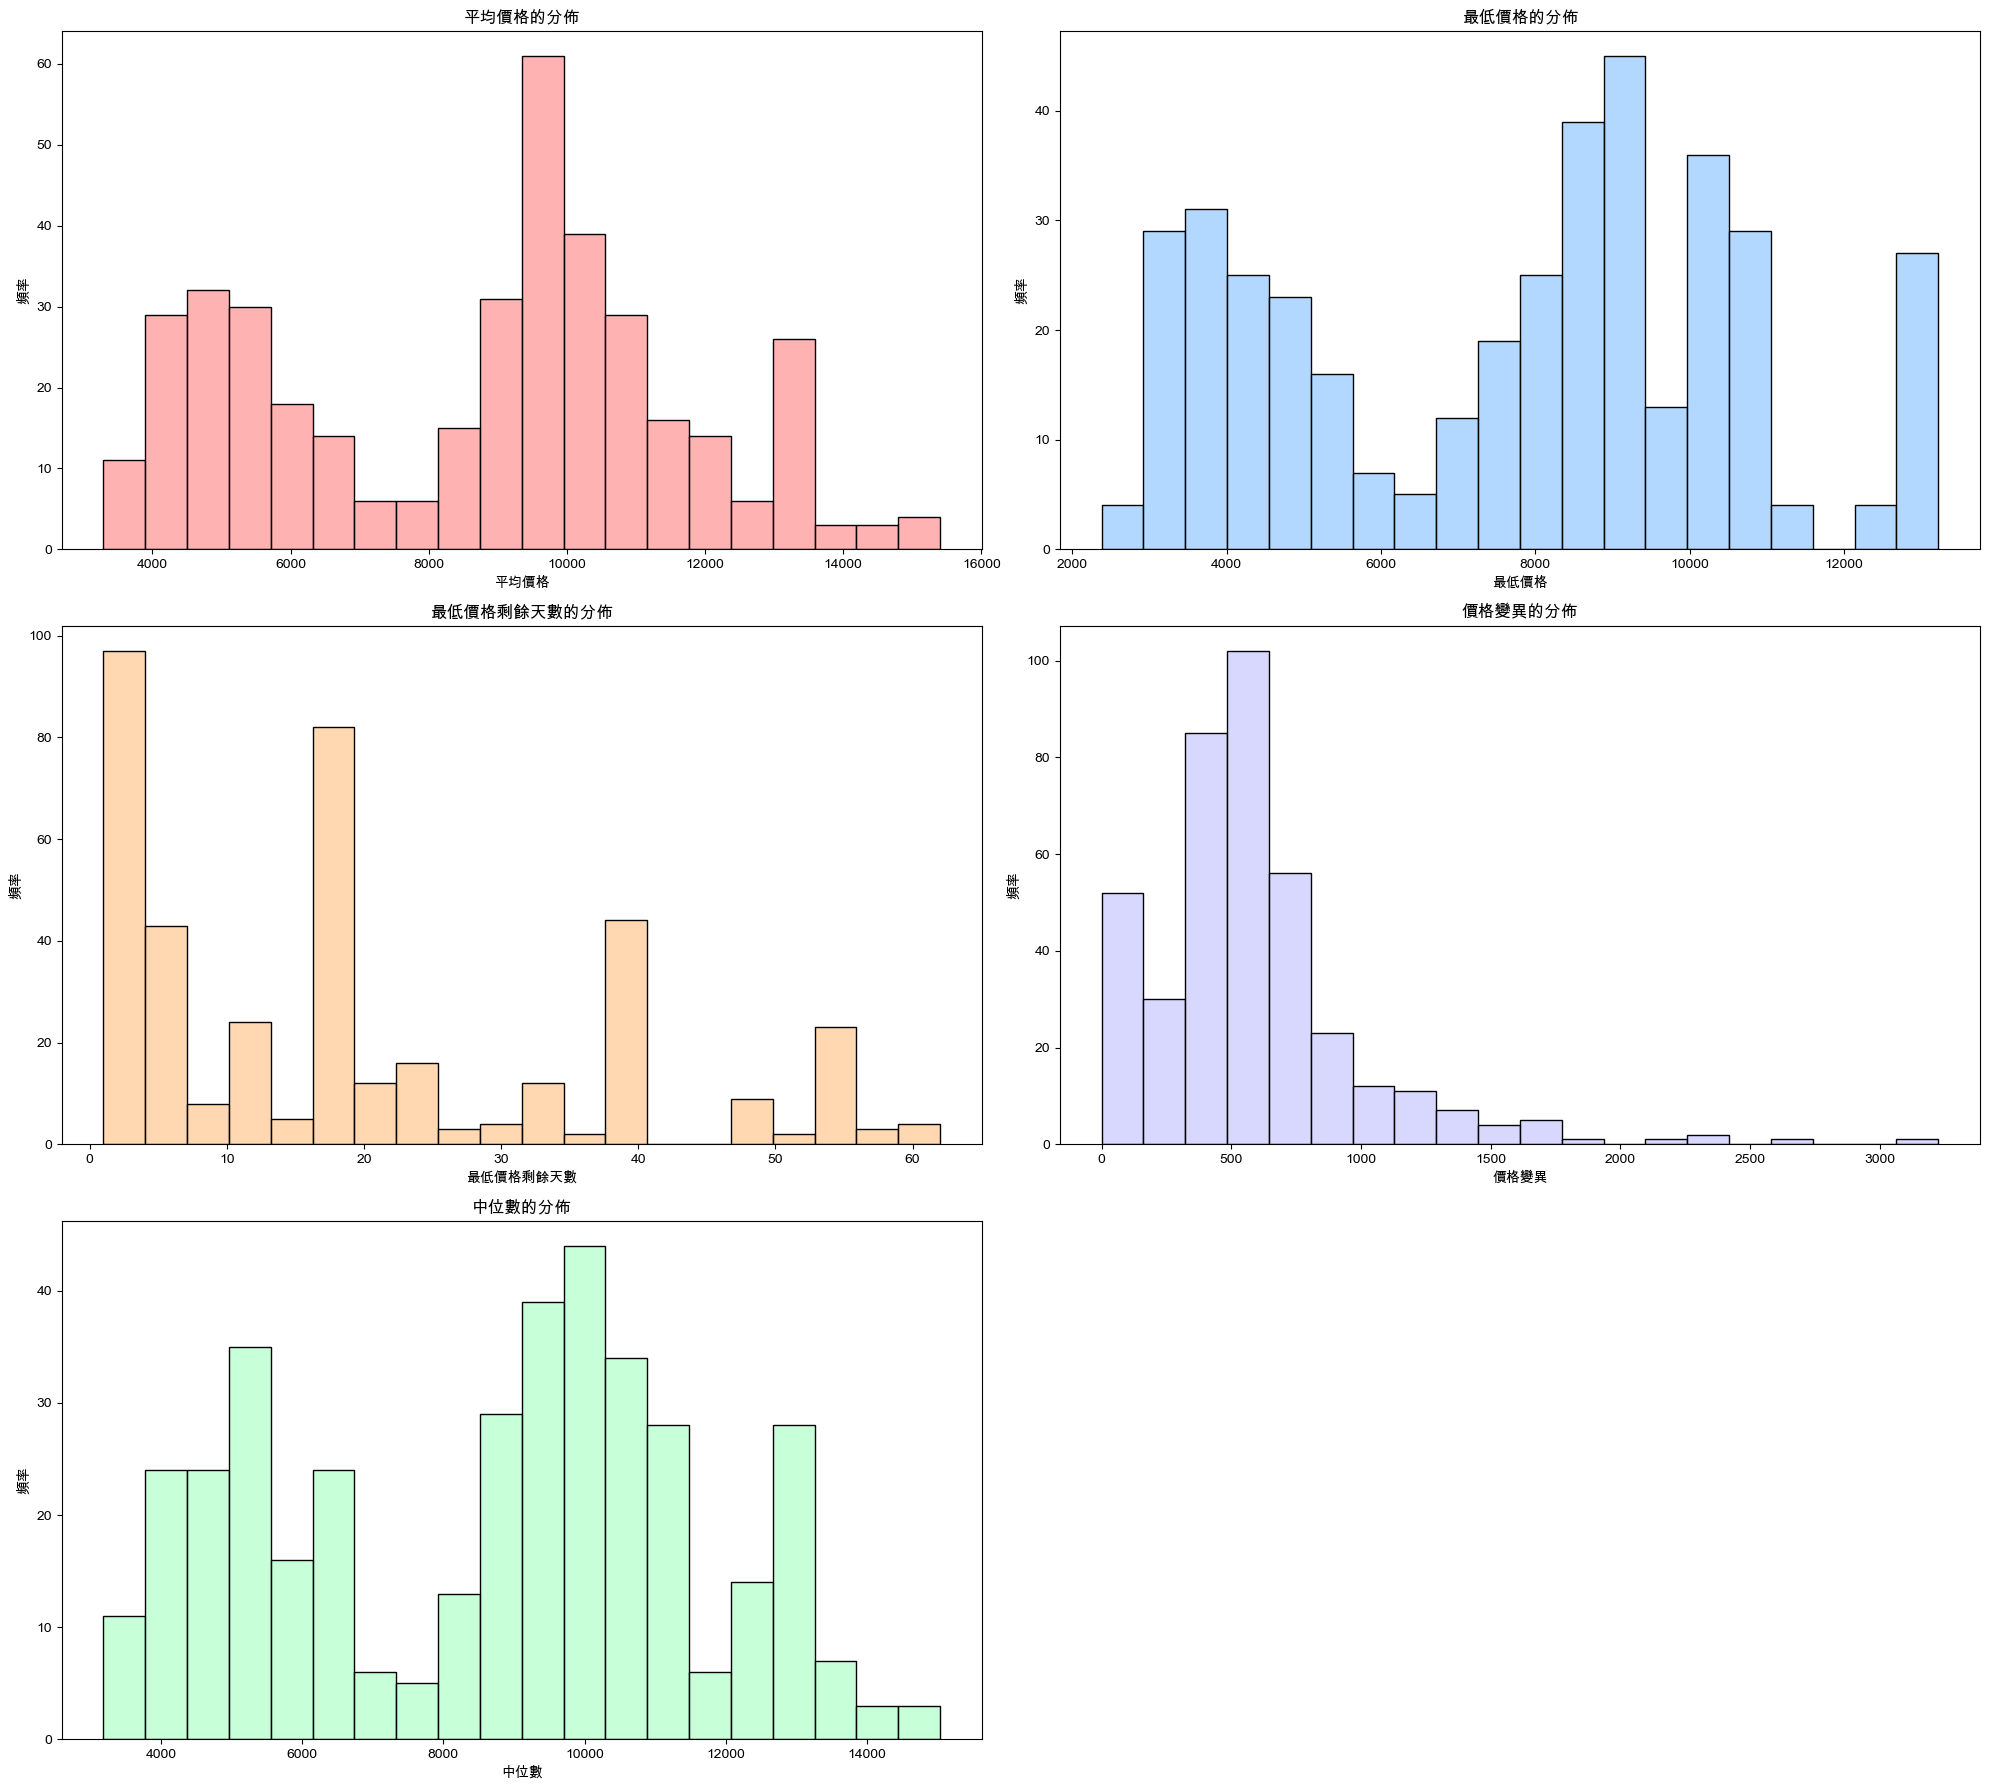

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 確保對數轉換時不會影響原始 DataFrame
plot_data = plot_data.copy()

# 創建子圖，分別繪製平均價格、最低價格、最低價格剩餘天數、價格變異和中位數的直方圖
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # 更新為 3x2 布局
bins = 20  # 設定直方圖的 bin 數量

# 第一個子圖：平均價格的直方圖
sns.histplot(plot_data['歷史價格平均'], bins=bins, kde=False, color='#FF9999', ax=axes[0, 0])
axes[0, 0].set_title('平均價格的分佈')
axes[0, 0].set_xlabel('平均價格')
axes[0, 0].set_ylabel('頻率')

# 第二個子圖：最低價格的直方圖
sns.histplot(plot_data['最低價格'], bins=bins, kde=False, color='#99CCFF', ax=axes[0, 1])
axes[0, 1].set_title('最低價格的分佈')
axes[0, 1].set_xlabel('最低價格')
axes[0, 1].set_ylabel('頻率')

# 第三個子圖：最低價格剩餘天數的直方圖
sns.histplot(plot_data['最低價格剩餘天數'], bins=bins, kde=False, color='#FFCC99', ax=axes[1, 0])
axes[1, 0].set_title('最低價格剩餘天數的分佈')
axes[1, 0].set_xlabel('最低價格剩餘天數')
axes[1, 0].set_ylabel('頻率')

# 第四個子圖：價格變異的直方圖
sns.histplot(plot_data['變異'], bins=bins, kde=False, color='#CCCCFF', ax=axes[1, 1])
axes[1, 1].set_title('價格變異的分佈')
axes[1, 1].set_xlabel('價格變異')
axes[1, 1].set_ylabel('頻率')

# 第五個子圖：中位數的直方圖
sns.histplot(plot_data['中位數'], bins=bins, kde=False, color='#B3FFCC', ax=axes[2, 0])
axes[2, 0].set_title('中位數的分佈')
axes[2, 0].set_xlabel('中位數')
axes[2, 0].set_ylabel('頻率')

# 移除未使用的第六個子圖
axes[2, 1].axis('off')

# 調整佈局
plt.tight_layout()
plt.show()

**取對數：Histogram 平均價格跟最低價格跟最低價格剩餘天數變異跟中位數（按是否紅眼航班分類**

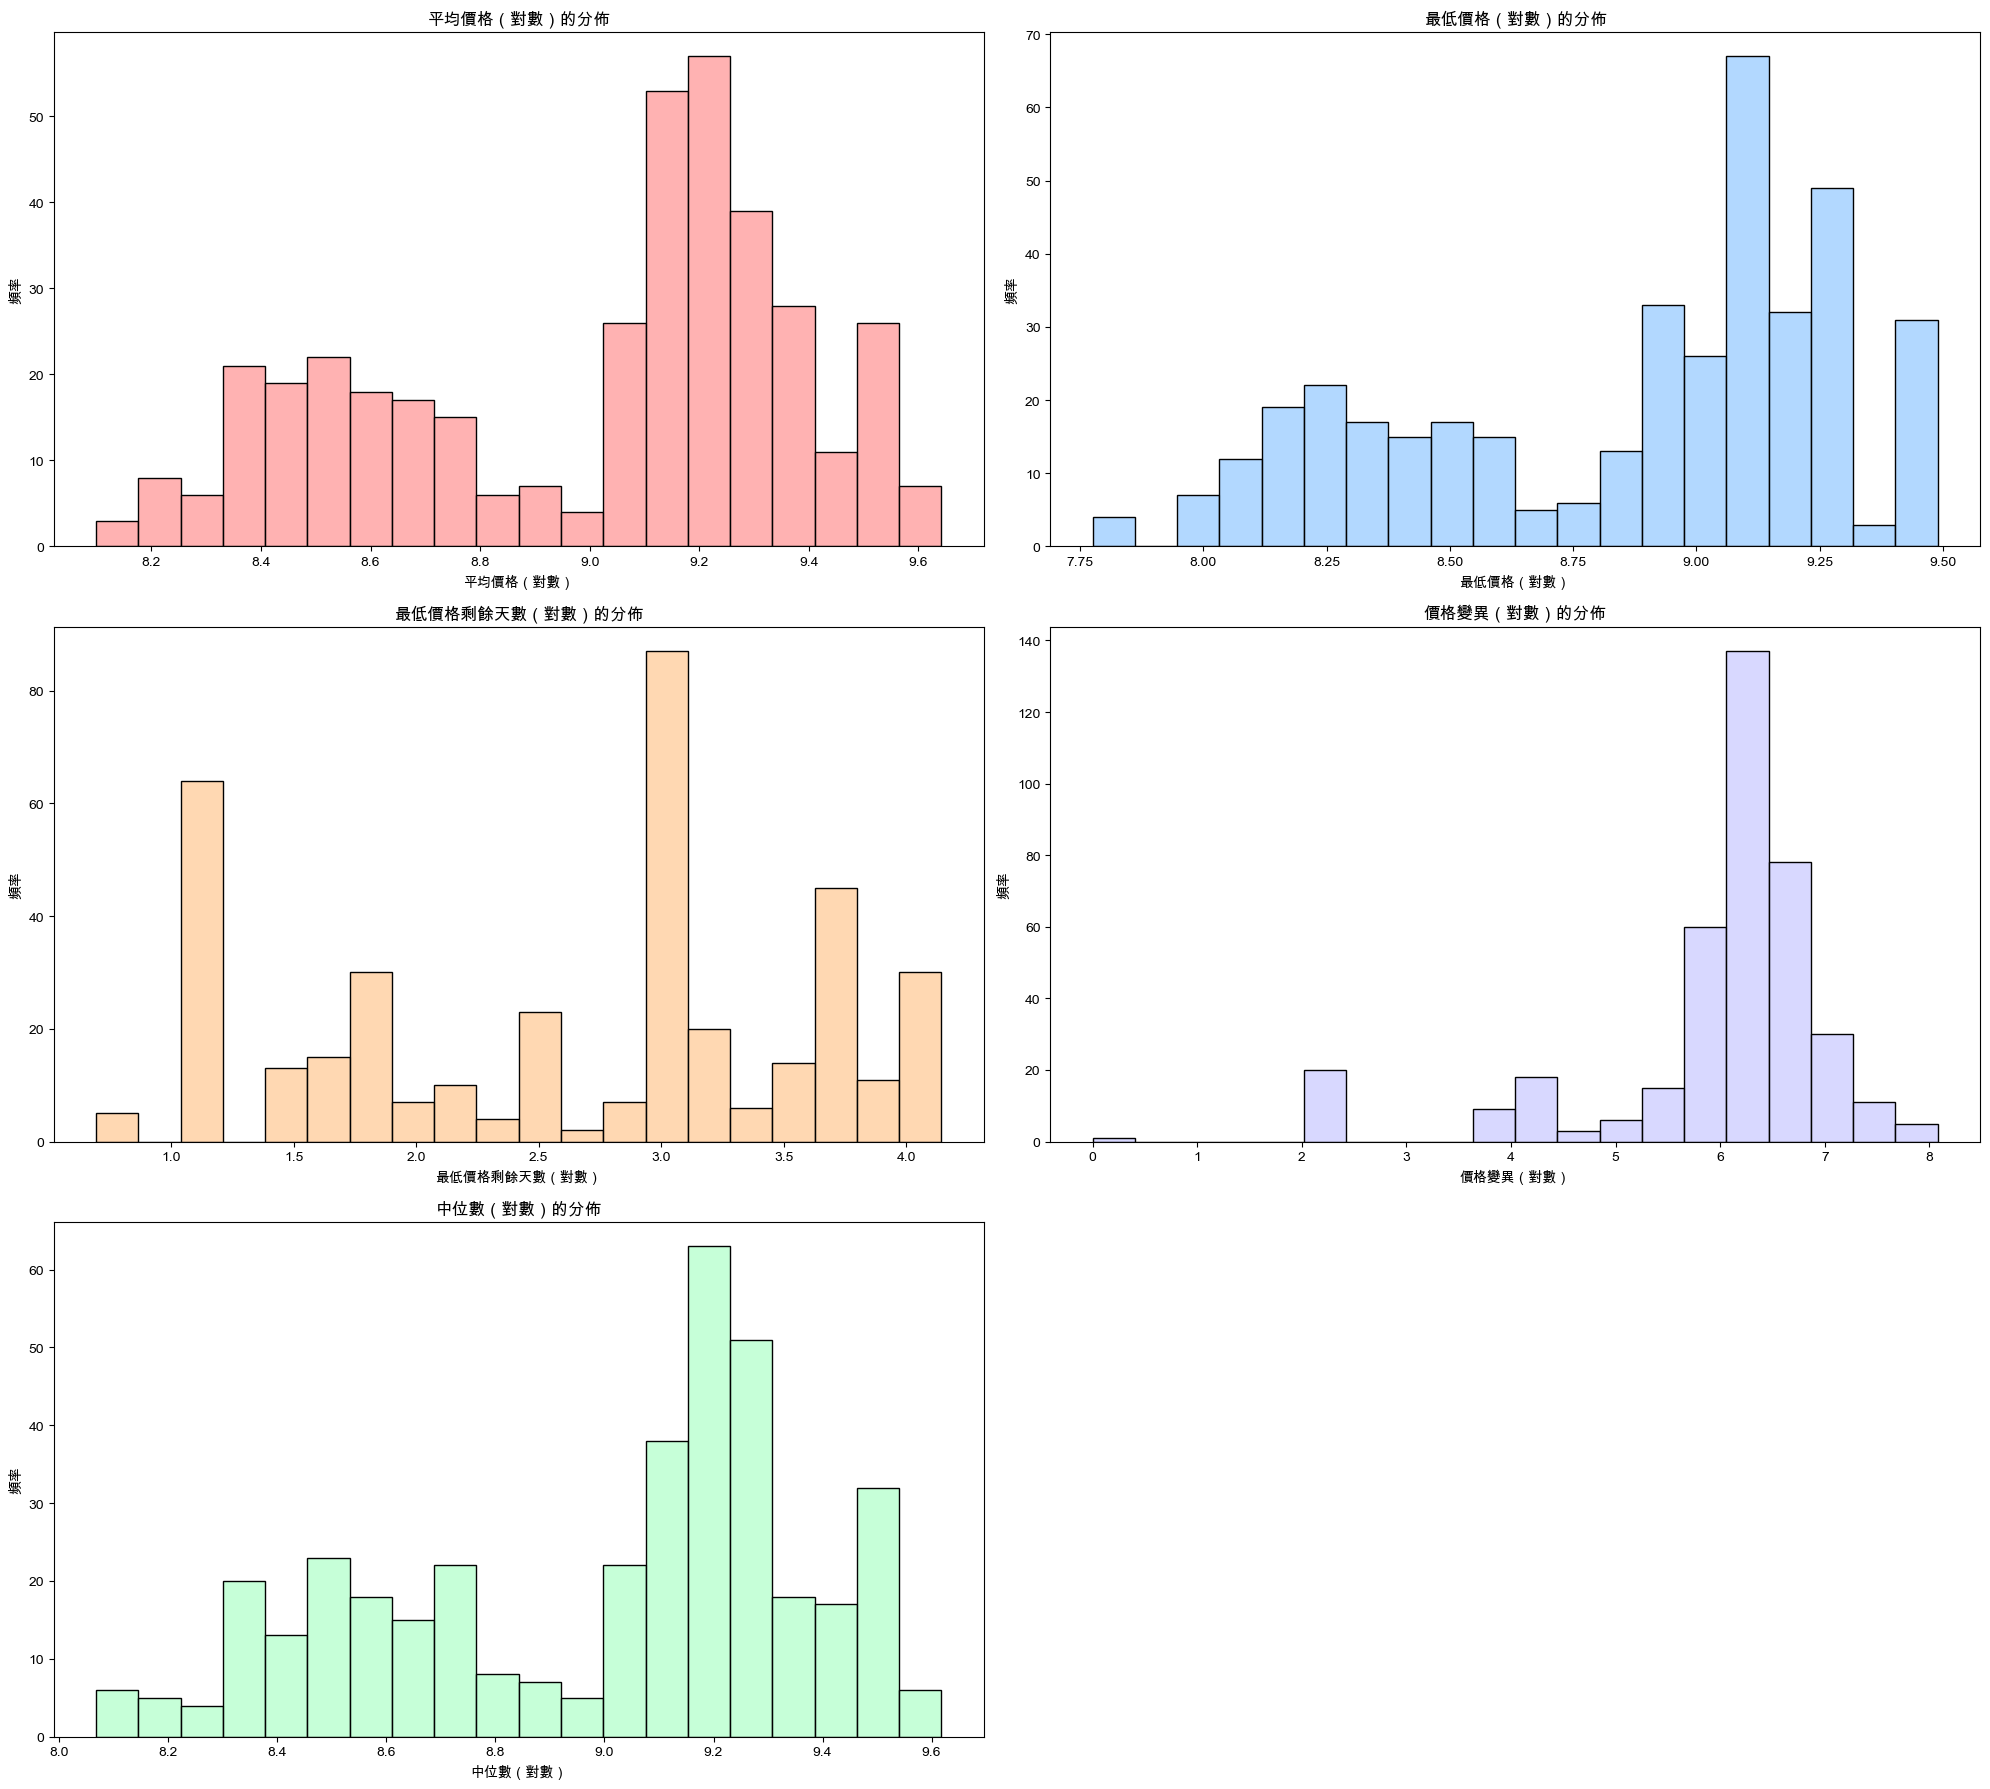

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 確保對數轉換時不會影響原始 DataFrame
plot_data = plot_data.copy()

# 將數據取對數，避免 log(0) 的錯誤，將數據加 1 後取對數
plot_data['歷史價格平均_log'] = np.log(plot_data['歷史價格平均'] + 1)
plot_data['最低價格_log'] = np.log(plot_data['最低價格'] + 1)
plot_data['最低價格剩餘天數_log'] = np.log(plot_data['最低價格剩餘天數'] + 1)
plot_data['變異_log'] = np.log(plot_data['變異'] + 1)
plot_data['中位數_log'] = np.log(plot_data['中位數'] + 1)

# 創建子圖，分別繪製平均價格（對數）、最低價格（對數）、最低價格剩餘天數（對數）、價格變異（對數）和中位數（對數）的直方圖
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
bins = 20  # 設定直方圖的 bin 數量

# 第一個子圖：平均價格（對數）的直方圖
sns.histplot(plot_data['歷史價格平均_log'], bins=bins, kde=False, color='#FF9999', ax=axes[0, 0])
axes[0, 0].set_title('平均價格（對數）的分佈')
axes[0, 0].set_xlabel('平均價格（對數）')
axes[0, 0].set_ylabel('頻率')

# 第二個子圖：最低價格（對數）的直方圖
sns.histplot(plot_data['最低價格_log'], bins=bins, kde=False, color='#99CCFF', ax=axes[0, 1])
axes[0, 1].set_title('最低價格（對數）的分佈')
axes[0, 1].set_xlabel('最低價格（對數）')
axes[0, 1].set_ylabel('頻率')

# 第三個子圖：最低價格剩餘天數（對數）的直方圖
sns.histplot(plot_data['最低價格剩餘天數_log'], bins=bins, kde=False, color='#FFCC99', ax=axes[1, 0])
axes[1, 0].set_title('最低價格剩餘天數（對數）的分佈')
axes[1, 0].set_xlabel('最低價格剩餘天數（對數）')
axes[1, 0].set_ylabel('頻率')

# 第四個子圖：價格變異（對數）的直方圖
sns.histplot(plot_data['變異_log'], bins=bins, kde=False, color='#CCCCFF', ax=axes[1, 1])
axes[1, 1].set_title('價格變異（對數）的分佈')
axes[1, 1].set_xlabel('價格變異（對數）')
axes[1, 1].set_ylabel('頻率')

# 第五個子圖：中位數（對數）的直方圖
sns.histplot(plot_data['中位數_log'], bins=bins, kde=False, color='#B3FFCC', ax=axes[2, 0])
axes[2, 0].set_title('中位數（對數）的分佈')
axes[2, 0].set_xlabel('中位數（對數）')
axes[2, 0].set_ylabel('頻率')

# 隱藏第六個子圖（無數據）
axes[2, 1].axis('off')

# 調整佈局
plt.tight_layout()
plt.show()

**取對數：常態檢定**

In [25]:
from scipy.stats import shapiro
import numpy as np

# 確保對數轉換時不會影響原始 DataFrame
plot_data = plot_data.copy()

# 新增中位數（對數）
plot_data['中位數_log'] = np.log(plot_data['中位數'] + 1)

# 包含中位數（對數）的變數
variables_log = {
    '平均價格（對數）': plot_data['歷史價格平均_log'],
    '最低價格（對數）': plot_data['最低價格_log'],
    '最低價格剩餘天數（對數）': plot_data['最低價格剩餘天數_log'],
    '價格變異（對數）': plot_data['變異_log'],
    '中位數（對數）': plot_data['中位數_log']
}

# 對每個變數進行 Shapiro-Wilk 檢定
for var_name, data in variables_log.items():
    stat, p_value = shapiro(data)
    print(f"{var_name} 的 Shapiro-Wilk 檢定 P 值: {p_value}")
    if p_value > 0.05:
        print(f"{var_name} 接近正態分佈")
    else:
        print(f"{var_name} 顯著偏離正態分佈")

平均價格（對數） 的 Shapiro-Wilk 檢定 P 值: 7.315345815486898e-14
平均價格（對數） 顯著偏離正態分佈
最低價格（對數） 的 Shapiro-Wilk 檢定 P 值: 6.740987160054305e-14
最低價格（對數） 顯著偏離正態分佈
最低價格剩餘天數（對數） 的 Shapiro-Wilk 檢定 P 值: 2.1985940995157276e-14
最低價格剩餘天數（對數） 顯著偏離正態分佈
價格變異（對數） 的 Shapiro-Wilk 檢定 P 值: 1.383186552724094e-23
價格變異（對數） 顯著偏離正態分佈
中位數（對數） 的 Shapiro-Wilk 檢定 P 值: 1.0736648577565489e-13
中位數（對數） 顯著偏離正態分佈


**取對數：顯著偏離正態分佈 用 Kruskal-Wallis Test**

In [26]:
from scipy.stats import kruskal

# 確保對數轉換時不會影響原始 DataFrame
plot_data = plot_data.copy()

# 新增中位數（對數）
plot_data['中位數_log'] = np.log(plot_data['中位數'] + 1)

# 包含中位數（對數）的變數
variables_log = {
    '平均價格（對數）': plot_data['歷史價格平均_log'],
    '最低價格（對數）': plot_data['最低價格_log'],
    '最低價格剩餘天數（對數）': plot_data['最低價格剩餘天數_log'],
    '價格變異（對數）': plot_data['變異_log'],
    '中位數（對數）': plot_data['中位數_log']
}

# 對每個變數進行 Kruskal-Wallis 檢定
for var_name, data in variables_log.items():
    red_eye_data = data[plot_data['紅眼航班'] == 1]
    non_red_eye_data = data[plot_data['紅眼航班'] == 0]
    
    stat, p_value = kruskal(red_eye_data, non_red_eye_data)
    print(f"{var_name} 的 Kruskal-Wallis 檢定 P 值: {p_value}")
    if p_value < 0.05:
        print(f"{var_name} 在紅眼航班與非紅眼航班之間有顯著差異")
    else:
        print(f"{var_name} 在紅眼航班與非紅眼航班之間沒有顯著差異")

平均價格（對數） 的 Kruskal-Wallis 檢定 P 值: 1.891410634020513e-12
平均價格（對數） 在紅眼航班與非紅眼航班之間有顯著差異
最低價格（對數） 的 Kruskal-Wallis 檢定 P 值: 4.3401917611406486e-14
最低價格（對數） 在紅眼航班與非紅眼航班之間有顯著差異
最低價格剩餘天數（對數） 的 Kruskal-Wallis 檢定 P 值: 0.08630828522018535
最低價格剩餘天數（對數） 在紅眼航班與非紅眼航班之間沒有顯著差異
價格變異（對數） 的 Kruskal-Wallis 檢定 P 值: 0.33431650156415754
價格變異（對數） 在紅眼航班與非紅眼航班之間沒有顯著差異
中位數（對數） 的 Kruskal-Wallis 檢定 P 值: 1.2157185191488454e-12
中位數（對數） 在紅眼航班與非紅眼航班之間有顯著差異


**取對數：Boxplot/Histogram**
平均價格跟最低價格（按是否紅眼航班分類）

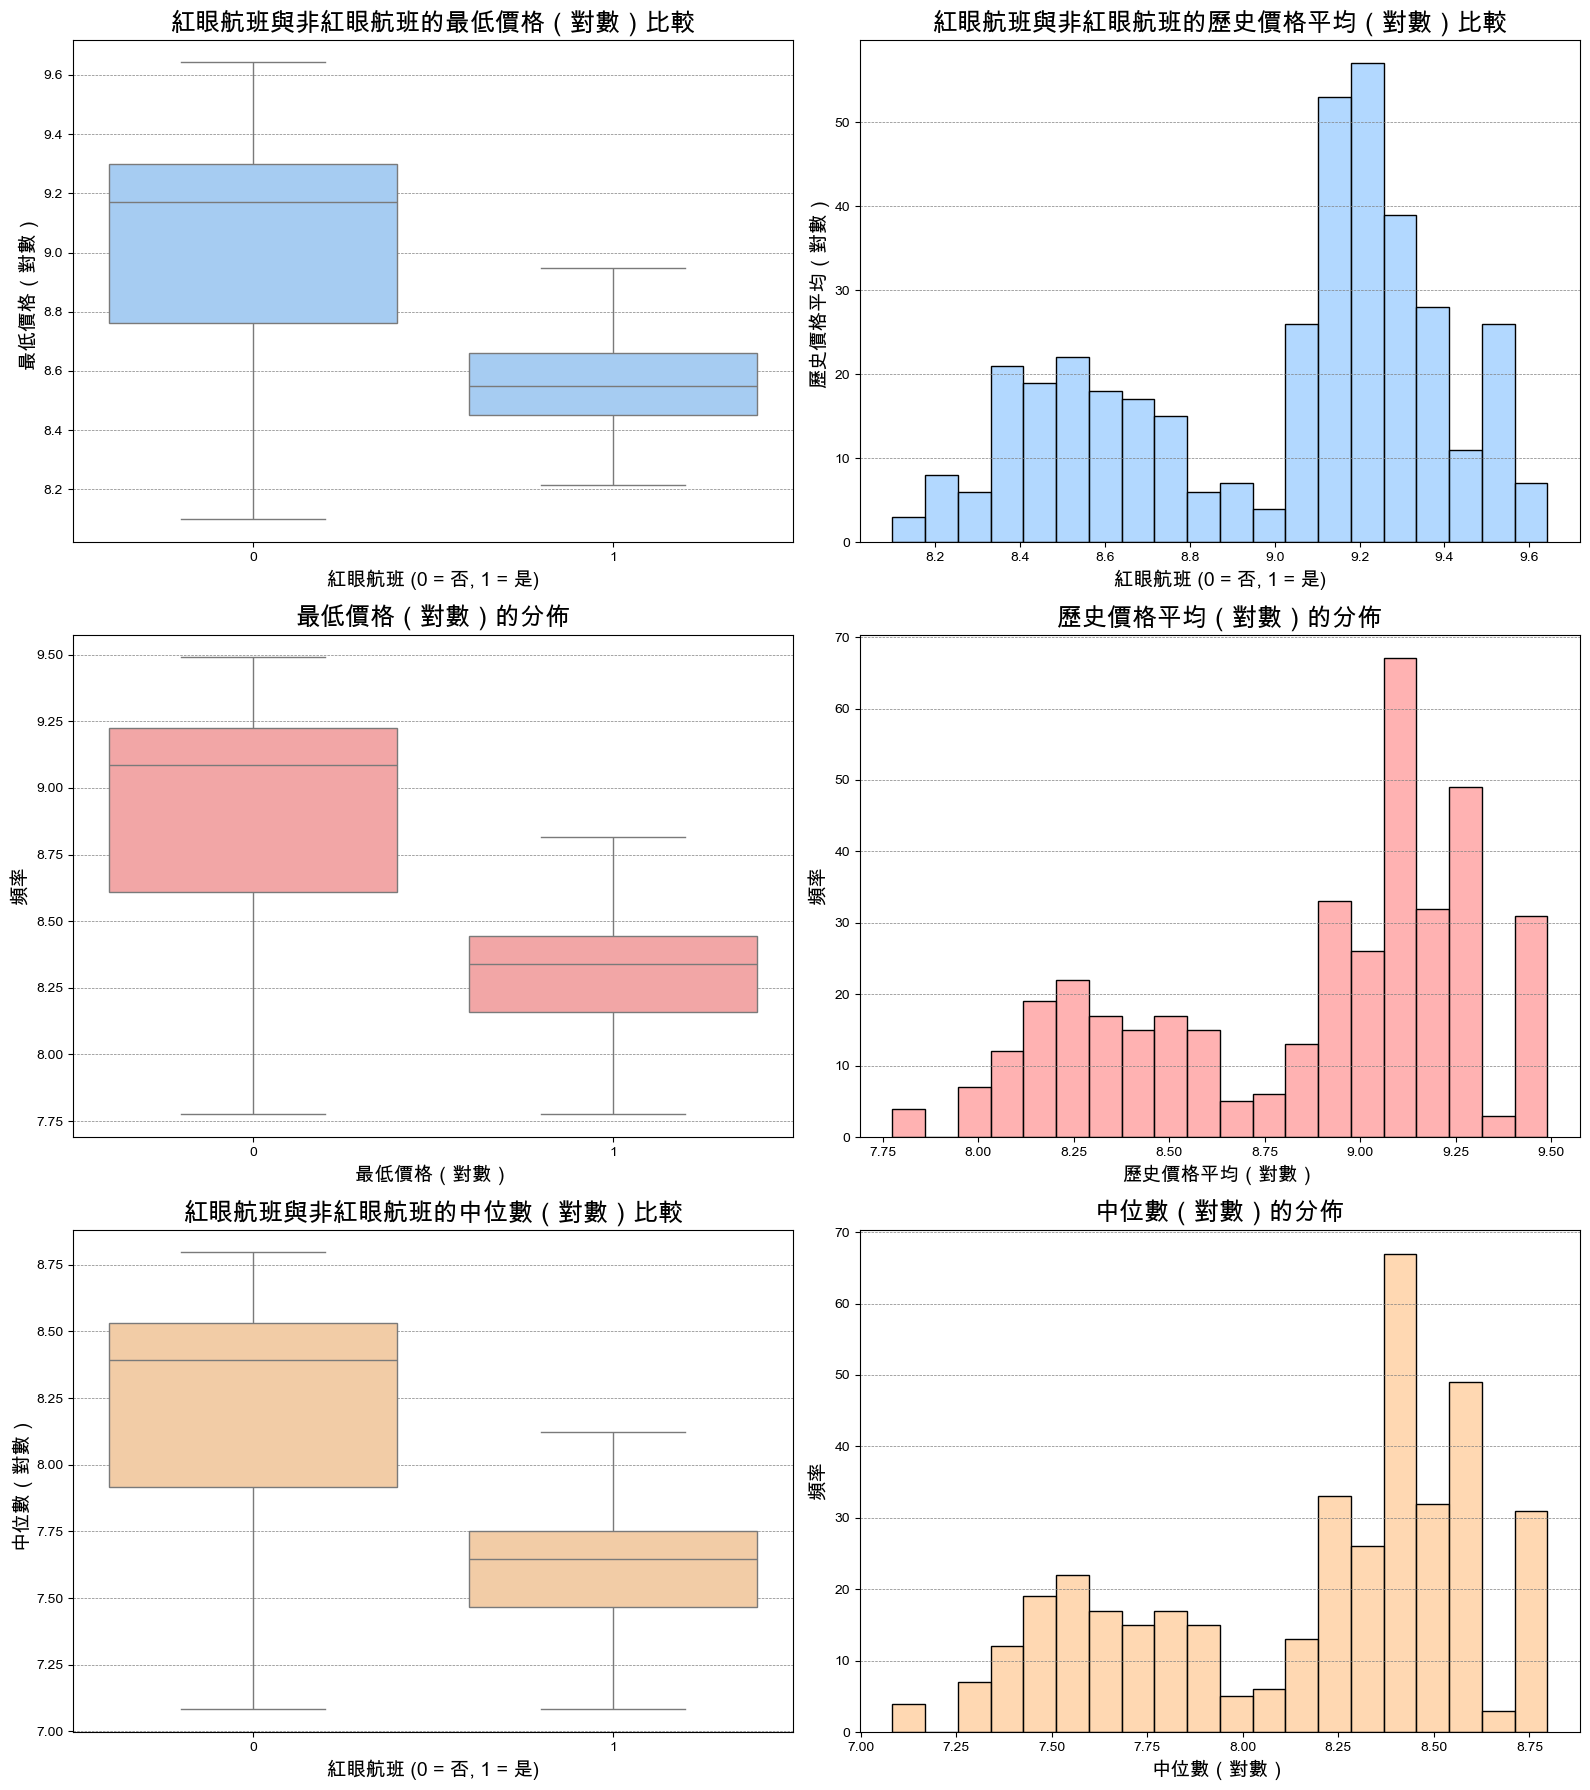

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 確保對數轉換時不會影響原始 DataFrame
plot_data = plot_data.copy()

plot_data['最低價格_對數'] = np.log(plot_data['最低價格'] + 1)
plot_data['歷史價格平均_對數'] = np.log(plot_data['歷史價格平均'] + 1)
plot_data['中位數_對數'] = np.log(plot_data['中位數'] + 1)  # 如果需要中位數對數

# 創建 3x2 子圖
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 調整字體大小
title_fontsize = 18
label_fontsize = 14

# 第一行子圖：最低價格和歷史價格平均（對數）的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均_對數', ax=axes[0, 0], color='#99CCFF')
axes[0, 1].set_title('紅眼航班與非紅眼航班的歷史價格平均（對數）比較', fontsize=title_fontsize)
axes[0, 1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('歷史價格平均（對數）', fontsize=label_fontsize)
axes[0, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

sns.histplot(plot_data['歷史價格平均_對數'], kde=False, color='#99CCFF', ax=axes[0, 1], bins=20)
axes[1, 1].set_title('歷史價格平均（對數）的分佈', fontsize=title_fontsize)
axes[1, 1].set_xlabel('歷史價格平均（對數）', fontsize=label_fontsize)
axes[1, 1].set_ylabel('頻率', fontsize=label_fontsize)
axes[1, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)


# 第二行子圖：最低價格和歷史價格平均（對數）的直方圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格_對數', ax=axes[1, 0], color='#FF9999')
axes[0, 0].set_title('紅眼航班與非紅眼航班的最低價格（對數）比較', fontsize=title_fontsize)
axes[0, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[0, 0].set_ylabel('最低價格（對數）', fontsize=label_fontsize)
axes[0, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

sns.histplot(plot_data['最低價格_對數'], kde=False, color='#FF9999', ax=axes[1, 1], bins=20)
axes[1, 0].set_title('最低價格（對數）的分佈', fontsize=title_fontsize)
axes[1, 0].set_xlabel('最低價格（對數）', fontsize=label_fontsize)
axes[1, 0].set_ylabel('頻率', fontsize=label_fontsize)
axes[1, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第三行子圖：中位數（對數）的盒狀圖和直方圖
sns.boxplot(data=plot_data, x='紅眼航班', y='中位數_對數', ax=axes[2, 0], color='#FFCC99')
axes[2, 0].set_title('紅眼航班與非紅眼航班的中位數（對數）比較', fontsize=title_fontsize)
axes[2, 0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)', fontsize=label_fontsize)
axes[2, 0].set_ylabel('中位數（對數）', fontsize=label_fontsize)
axes[2, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

sns.histplot(plot_data['中位數_對數'], kde=False, color='#FFCC99', ax=axes[2, 1], bins=20)
axes[2, 1].set_title('中位數（對數）的分佈', fontsize=title_fontsize)
axes[2, 1].set_xlabel('中位數（對數）', fontsize=label_fontsize)
axes[2, 1].set_ylabel('頻率', fontsize=label_fontsize)
axes[2, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()